# Corrector Coil

Here we will make a corrector coil as a 3D Cartesian grid and track.



In [1]:
import numpy as np
from math import pi
from scipy.constants import c
import os

from pmd_beamphysics.fields.corrector_modeling import make_dipole_corrector_fieldmesh 

from impact import Impact

# Create FieldMesh

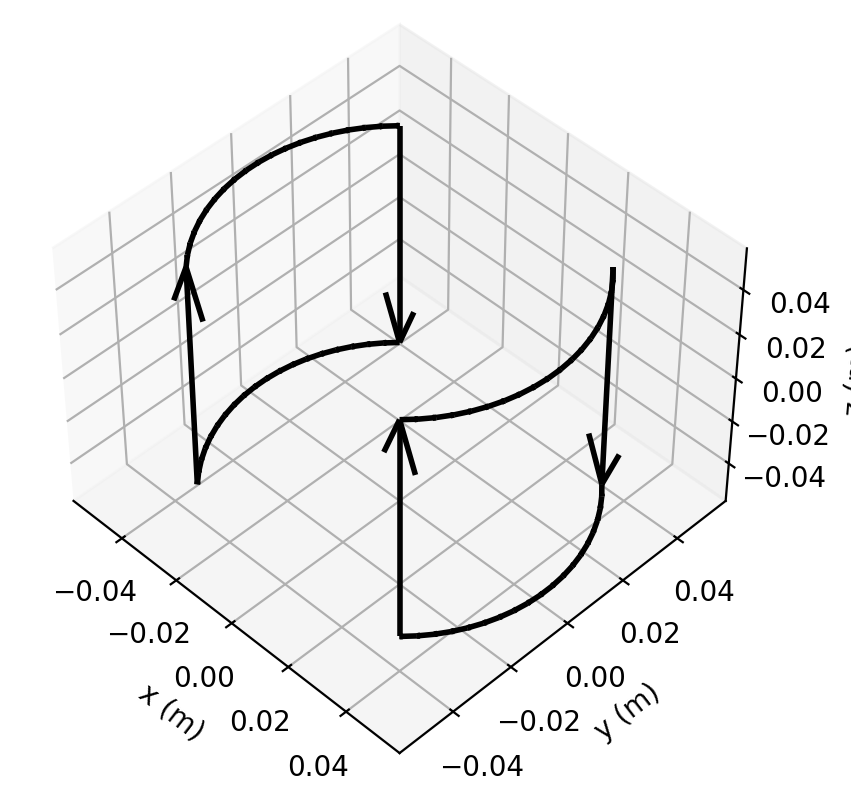

In [2]:
R = 2*2.54e-2      # 2" radius [m]
L = 0.1            # Length along z [m]
theta = np.pi/2    # Opening angle [rad]
current=100          # Current [Amp]

FM = make_dipole_corrector_fieldmesh(current=current,
                                     xmin=-R, xmax=R, nx=21,
                                     ymin=-R, ymax=R, ny=21,
                                     zmin=-5*L/2, zmax=5*L/2, nz=101,
                                     mode='saddle',
                                     R=R, L=L, theta=theta, npts=20, 
                                     plot_wire=True,
                                    tilt=pi/2)

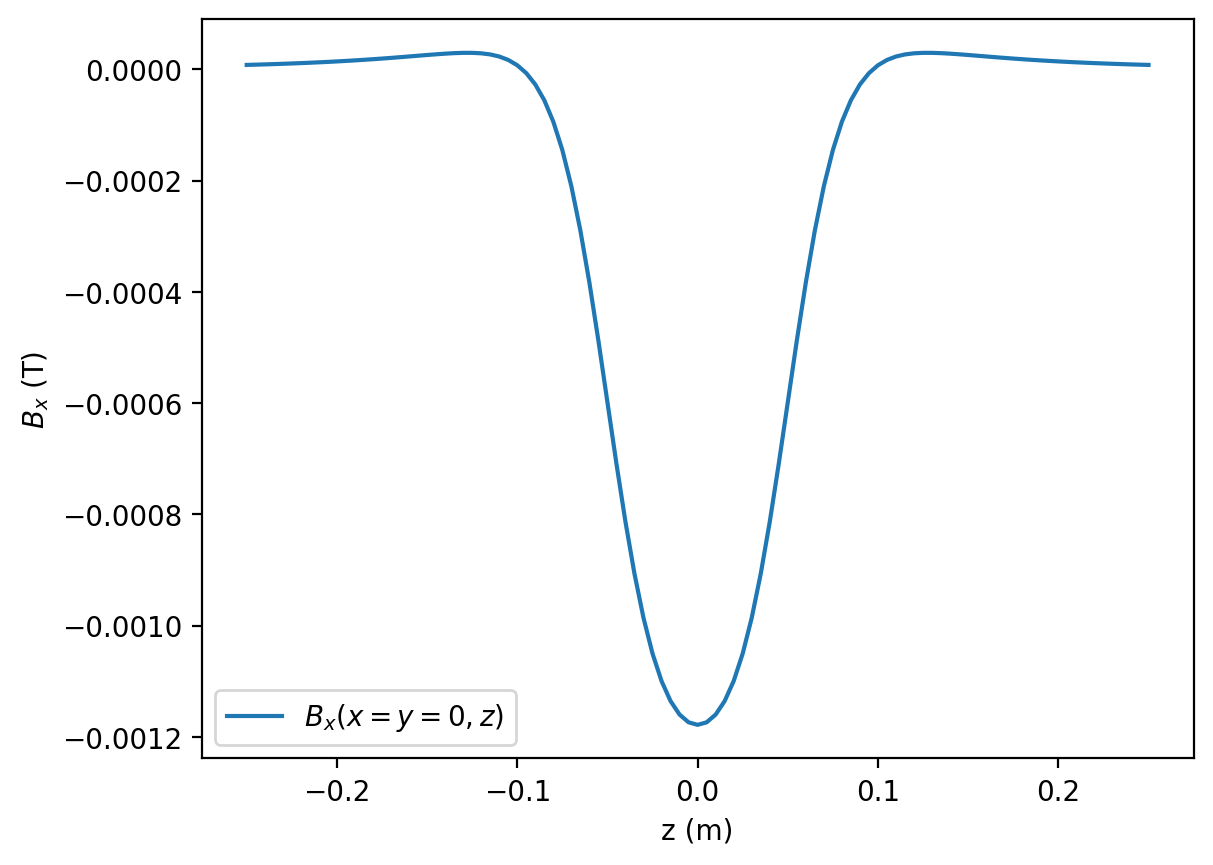

In [3]:
FM.plot_onaxis('Bx')

# Prepare for Impact-T

In [4]:
FM.write_impact_emfield_cartesian('1T1.T7')

In [5]:
!head '1T1.T7'

-0.0508 0.0508 20
-0.0508 0.0508 20
-0.25 0.25 100
(0.0,0.0) (0.0,0.0) (0.0,0.0) (6.684101581996648e-06,0.0) (-7.266778003195612e-07,0.0) (-3.832293470128711e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (6.867885527490154e-06,0.0) (-6.614977401434097e-07,0.0) (-3.493227085162304e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (7.034992614025955e-06,0.0) (-5.939637921746227e-07,0.0) (-3.1404822137044146e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (7.184518169950735e-06,0.0) (-5.243279883966475e-07,0.0) (-2.77541815932583e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (7.315669701741123e-06,0.0) (-4.5284851137982327e-07,0.0) (-2.3994599263345756e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (7.427767324448469e-06,0.0) (-3.7978735920463357e-07,0.0) (-2.014085091796e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (7.520242576441565e-06,0.0) (-3.054084757601336e-07,0.0) (-1.6208119857874111e-06,0.0)


In [6]:
!ls -ahl

total 12472
drwxr-xr-x   8 chrisonian  staff   256B Oct 18 12:52 .
drwxr-xr-x  20 chrisonian  staff   640B Oct 15 18:12 ..
drwxr-xr-x   7 chrisonian  staff   224B Oct 15 18:49 .ipynb_checkpoints
-rw-r--r--   1 chrisonian  staff   4.9M Oct 18 12:52 1T1.T7
-rw-r--r--   1 chrisonian  staff   741B Oct 18 11:16 ImpactT.in
-rw-r--r--   1 chrisonian  staff   691K Oct 18 12:34 bmad_to_impact.ipynb
-rw-r--r--   1 chrisonian  staff   487K Oct 18 12:34 corrector_coil.ipynb
-rw-r--r--   1 chrisonian  staff   580B Oct 18 11:38 lat.bmad


# Run Impact-T

In [7]:
I = Impact('ImpactT.in')
I.ele['COIL']#['rf_field_scale'] = 1

{'description': 'name:COIL',
 'original': '0.5 0 0 111 0.0 1 0.0 0 1 0.02 0.0 0.0 0.0 0.0 0.0 /!name:COIL',
 'L': 0.5,
 'type': 'emfield_cartesian',
 'zedge': 0.0,
 'rf_field_scale': 1.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': '1T1.T7',
 'radius': 0.02,
 's': 0.5,
 'name': 'COIL'}

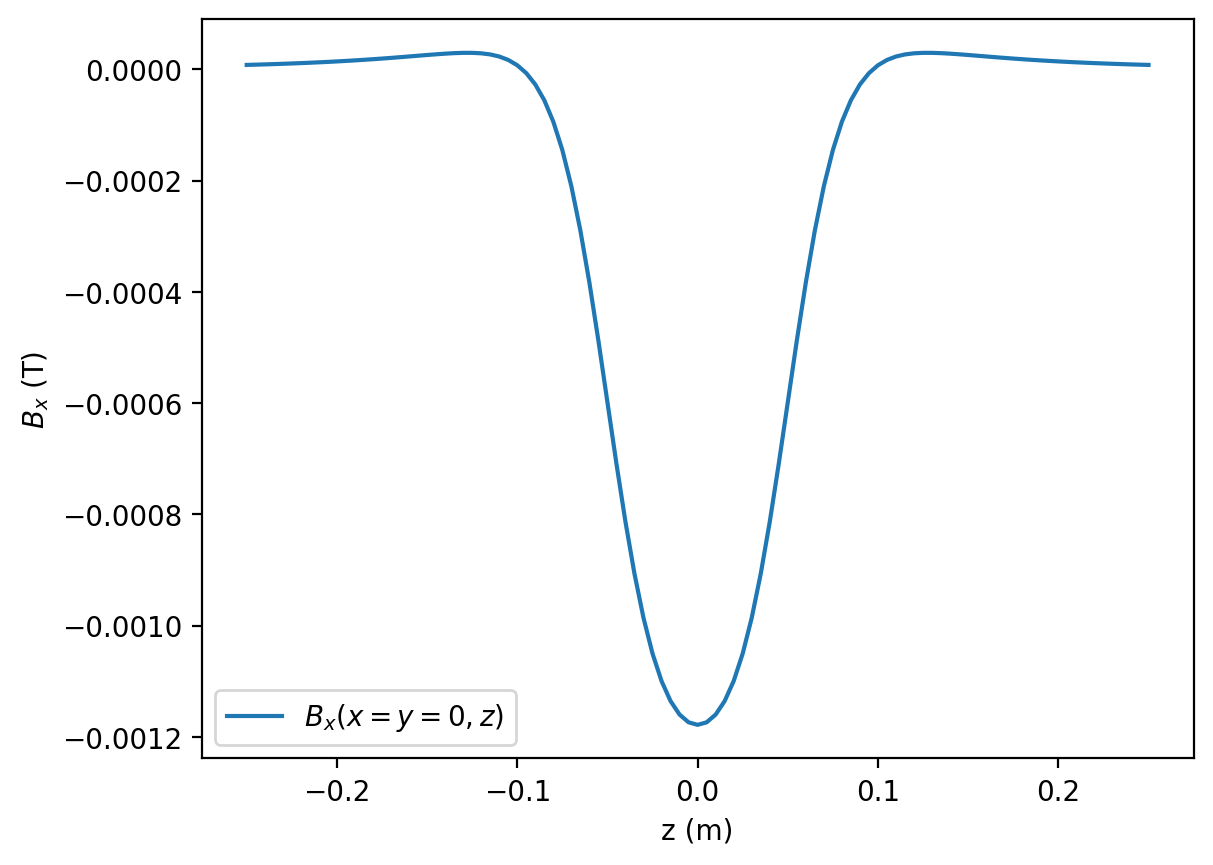

In [8]:
FM = I.fieldmaps['1T1.T7']['field']
FM.plot_onaxis('Bx')

In [9]:
I.ele['COIL']

{'description': 'name:COIL',
 'original': '0.5 0 0 111 0.0 1 0.0 0 1 0.02 0.0 0.0 0.0 0.0 0.0 /!name:COIL',
 'L': 0.5,
 'type': 'emfield_cartesian',
 'zedge': 0.0,
 'rf_field_scale': 1.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': '1T1.T7',
 'radius': 0.02,
 's': 0.5,
 'name': 'COIL'}

In [10]:
I.fieldmaps['1T1.T7']

{'info': {'format': 'emfield_cartesian_fieldmesh'},
 'field': <FieldMesh with rectangular geometry and (21, 21, 101) shape at 0x12721ab70>}

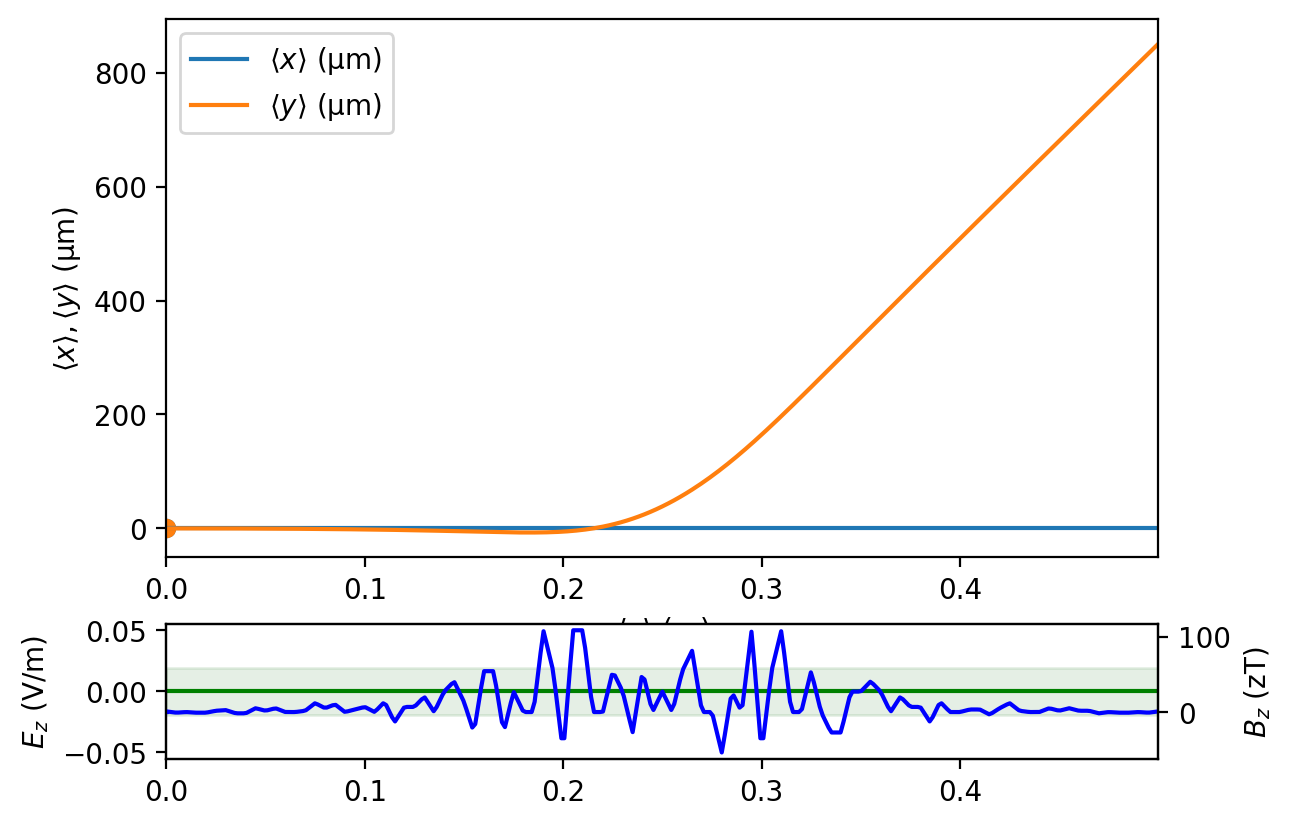

In [11]:
pz0=10e6

I.track1(pz0=pz0)

I.plot(['mean_x', 'mean_y'])

# Check field integral

In [12]:
z0 = FM.coord_vec('z')
Bx0 = np.real(FM.Bx[FM.shape[0]//2, FM.shape[1]//2, :]) 

BL = np.trapezoid(Bx0, z0)

BL

np.float64(-0.00011352149537307127)

In [13]:
theta0 = -BL*c/pz0

theta0

np.float64(0.0034032888133728664)

In [14]:
I.track1(pz0=pz0)
theta1 = I.particles['final_particles'].py/pz0

theta1

array([0.00340284])

In [15]:
rel_diff = abs(theta1/theta0 -1)
rel_diff

array([0.00013244])

# Check that both are close

In [16]:
assert rel_diff < 1e-3

# Cleanup

In [17]:
os.remove('1T1.T7')